## A dumb hessian bound

\begin{align}
\frac{d^2f(\theta)}{d\theta^2} &= \int_{x \in F(\theta)} \frac{d^2 p}{d\theta^2} (x | \theta) dx \tag*{(exchange int/diff)}\\
\end{align}

\begin{align}
\frac{d^2f(\theta)}{d\theta^2} &\leq \int_{x \in F(\theta)} \max(0, \frac{d^2 p}{d\theta^2} (x | \theta)) dx  \tag*{(drop negative values)}\\ 
\end{align}

\begin{align}
\frac{d^2f(\theta)}{d\theta^2} &\leq \int_{x \in \Omega} \max(0, \frac{d^2 p}{d\theta^2} (x | \theta)) dx \tag*{(expand integration domain)}\\
\end{align}

Ending this one day mini-project since I got where I wanted to be:

I think we can probably do 2nd order bounds for any distribution with two well behaved derivatives.
the approach below requires doing a bunch of numerical integration, but the computational expense should be tiny compared to the cost of the 0/1 order bounds that require simulation.
but I think it’s nice to be able to honestly advertise that we can handle a much broader set of potential outcomes, with the qualification that we’d have to build some tools to do it reliably on a real problem.

Early this morning, I played around with doing a fully numerical hessian bound for the binomial case. Obviously this isn’t useful for binomial since we have a better bound, but it’s a case where I can compare to what we have already. 

Anyway, there are sort of three steps:
1. we can directly calculate the integral over the possible data!
2. then, we can max(0, hessian) to get an upper bound.
3. then, we can convert to a “fancy softmax” that gets us a smooth and differentiable upper bound. this is the first figure.

Then, the second figure shows:
1. actual bound as a function of the logit-space parameter, not too much worse than the analytical bound.
1. the analytical binomial variance bound derived for all exponential family (here 0.5 * n * p * (1 - p))
1. the gradient and hessian *of the bound*, computed with jax…, these required computing third and fourth derivatives of the mass function. these would be useful if we wanted to find the maximum of the bound over a tile.

## Weibull

In [2]:
from sage.all import *
import matplotlib.pyplot as plt
import numpy as np


def show_figure(fig):

    # create a dummy figure and use its
    # manager to display "fig"
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)

In [3]:
x, k, beta, L = var("x, k, beta, L")
assume(k, "integer")
assume(k - 1 > 0)
# assume(k > 0)
assume(beta > 0)
beta = 1

In [4]:
p = k * beta * (x * beta) ** (k - 1) * exp(-((x * beta) ** k))
d2pdk2 = diff(diff(p, k), k)

In [5]:
p._sympy_()

k*x**(k - 1)*exp(-x**k)

In [6]:
d2pdk2._sympy_()

k*x**(2*k)*x**(k - 1)*exp(-x**k)*log(x)**2 - 3*k*x**k*x**(k - 1)*exp(-x**k)*log(x)**2 + k*x**(k - 1)*exp(-x**k)*log(x)**2 - 2*x**k*x**(k - 1)*exp(-x**k)*log(x) + 2*x**(k - 1)*exp(-x**k)*log(x)

In [7]:
pos = p * (1 / k + log(x) * (1 - x**k)) ** 2
neg = p * (1 / (k**2) + x**k * log(x) ** 2)

In [8]:
# check that the pos, neg split matches the full expression
assert (d2pdk2 - (pos - neg)).full_simplify() == 0

# check the mean
mean = (p * x).subs(k == 0.5).nintegral(x, 0, 1000)
true_mean = 1.0 / beta * gamma(1 + 1 / 0.5)
print(mean[0], true_mean)

# look at pos, neg bound terms
def check(kv, a, b):
    P = pos.subs(k == kv).nintegral(x, a, b)
    N = neg.subs(k == kv).nintegral(x, a, b)
    return P[0], N[0]


for kv in [0.5, 1.0, 1.5]:
    print(check(kv, 0, 1000))

1.999999999980326 2.0
(7.294722646685907, 7.294722643138241)
(1.823680660852947, 1.823680660852742)
(0.8105247381393595, 0.8105247381568169)


In [9]:
for kv in np.linspace(0.5, 2.5, 6):
    pos_bound = pos.subs(k == kv).nintegral(x, 0, 1000)
    max0_bound = max_symbolic(0, d2pdk2).subs(k == kv).nintegral(x, 0, 1000)
    print(
        f"k={kv:.2f}, positive part bound={pos_bound[0]:.2f}, max0 bound={max0_bound[0]:.2f}"
    )

k=0.50, positive part bound=7.29, max0 bound=1.70
k=0.90, positive part bound=2.25, max0 bound=1.06
k=1.30, positive part bound=1.08, max0 bound=0.51
k=1.70, positive part bound=0.63, max0 bound=0.30
k=2.10, positive part bound=0.41, max0 bound=0.19
k=2.50, positive part bound=0.29, max0 bound=0.00


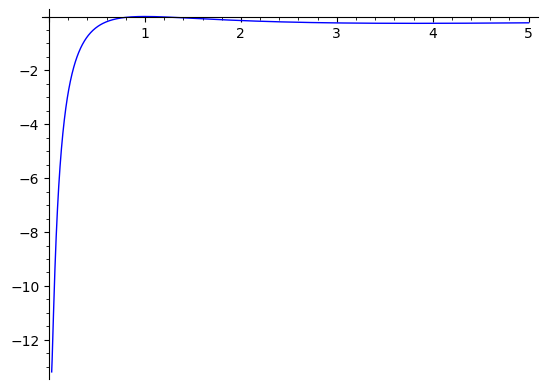

In [10]:
# Why does max(0, ...) work well? Lots of integrand lies below zero!
myplot = plot((pos - neg).subs(k == 0.5), (x, 0, 5))
pm = myplot.matplotlib()
show_figure(pm)

## Binomial

In [11]:
n, k, p = var("n, k, p")

In [12]:
# pmf = binomial(n, k) * p ** k * (1 - p) ** (n - k)
pmf = gamma(n + 1) / (gamma(k + 1) * gamma(n - k + 1)) * p**k * (1 - p) ** (n - k)
H = diff(diff(pmf, p), p)
boundH = max_symbolic(0, H)

In [13]:
eta = var("eta")
pmf_eta = pmf.subs(p == 1 / (1 + exp(-eta)))

In [14]:
Heta = diff(diff(pmf_eta, eta), eta)
boundHeta = max_symbolic(0, Heta)

In [15]:
tx = k
np = log(p / (1 - p))
hx = binomial(n, k)
Ap = -n * log(1 - p)

In [16]:
pmf2 = hx * exp(np * tx - Ap)
H2 = ((tx - diff(Ap, p)) ** 2 - diff(diff(Ap, p), p)) * pmf2

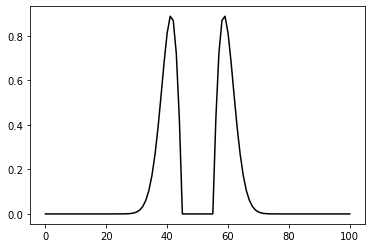

In [17]:
# plt.plot([H.subs(n == 100, p == 0.5, k == kv) for kv in range(0, 101)], 'r-')
# plt.plot([H2.subs(n == 100, p == 0.5, k == kv) for kv in range(0, 101)], 'r-')
# plt.plot([boundH.subs(n == 100, p == 0.5, k == kv) for kv in range(0, 101)], 'k-')
plt.plot(
    [
        boundHeta.subs(n == 100, eta == log(0.5 / (1 - 0.5)), k == kv)
        for kv in range(0, 101)
    ],
    "k-",
)
plt.show()

In [18]:
float(boundHeta.subs(n == 100, eta == log(0.5 / (1 - 0.5)), k == 40))

0.8132900033728491

In [19]:
import numpy as np

In [20]:
nv = 100
for pv in np.linspace(0, 1, 20)[1:-1]:
    bound = np.sum(
        [
            float(boundHeta.subs(n == nv, eta == log(pv / (1 - pv)), k == kv))
            for kv in range(0, nv + 1)
        ]
    )
    simple_bound = 0.5 * nv * pv * (1 - pv)
    print(bound, simple_bound)

2.3767610130416026 2.493074792243767
4.581111497855117 4.709141274238227
6.424833274271133 6.648199445983379
7.975176353848328 8.310249307479223
9.351703693747728 9.695290858725762
10.412324872129354 10.80332409972299
11.21822726915494 11.634349030470911
11.740438215225895 12.188365650969528
12.07689074070983 12.465373961218837
12.076890740709906 12.465373961218836
11.740438215225945 12.18836565096953
11.21822726915501 11.634349030470915
10.41232487212932 10.803324099722992
9.351703693747613 9.695290858725762
7.975176353848337 8.310249307479223
6.4248332742711725 6.648199445983381
4.581111497855133 4.709141274238231
2.3767610130415937 2.4930747922437697


## Is it possible to numerically integrate a PMF like the binomial one?

yes, sort of.

In [21]:
nv = 100
pv = 0.5
full_entries = [
    float(boundHeta.subs(n == nv, eta == log(pv / (1 - pv)), k == kv))
    for kv in range(0, nv + 1)
]
full = np.sum(full_entries)
full

11.997388415041613

In [22]:
np.arange(0, nv + 1)[np.where(np.array(full_entries) == 0)]

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55])

In [23]:
ogx, ogw = np.polynomial.legendre.leggauss(10)


def to_interval(a, b):
    return (ogx + 1) / 2 * (b - a) + a, ogw / 2 * (b - a)


def integrate(f, gx, gw):
    return np.sum(gw * [f.subs(k == kv) for kv in gx])


f = boundHeta.subs(n == nv, eta == log(pv / (1 - pv)))
v1 = integrate(f, *to_interval(0, 45)) + integrate(f, *to_interval(55, 100))

v2 = f.nintegral(k, 0, 100)

v1, v2[0]

(12.078563478355512, 12.07834207309084)

Note that this numerical integral above *has* converged. The reason it disagrees with the explicit pmf computation is that the domain is slightly different: integers vs reals.

Is this useful? Dunno, maybe.

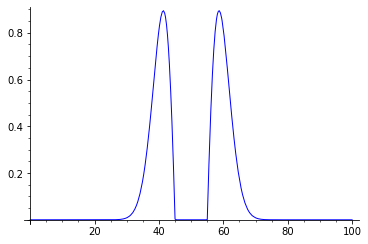

In [24]:
show_figure(plot(f, (k, 0, 100)).matplotlib())

## JAX stuff

In [207]:
import jax
import numpyro.distributions as dist
import jax.numpy as jnp

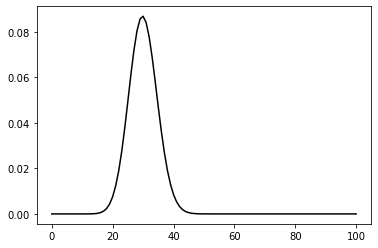

In [414]:
def pmf_jax_probs(eta, n, k):
    p = jax.scipy.special.expit(eta)
    return jnp.exp(dist.Binomial(n, probs=p).log_prob(k))


# def pmf_jax_logits(eta, n, k):
#     return jnp.exp(dist.Binomial(n, logits=eta).log_prob(k))
# dist.Binomial(100, probs=0.5).log_prob(30), dist.Binomial(100, logits=0).log_prob(30)
# pmf2 = pmf_jax_logits(jax.scipy.special.logit(0.5), 100, np.arange(0, 101))
# plt.plot(pmf2, 'b-')
# H = jax.hessian(pmf_jax_probs)(jax.scipy.special.logit(p), 100, np.arange(0, 101))
# H2 = jax.hessian(pmf_jax_logits)(jax.scipy.special.logit(p), 100, np.arange(0, 101))
# plt.plot(H)
# plt.plot(H2)
# plt.show()

p = 0.3
pmf = pmf_jax_probs(jax.scipy.special.logit(p), 100, np.arange(0, 101))
plt.plot(pmf, "k-")
plt.show()

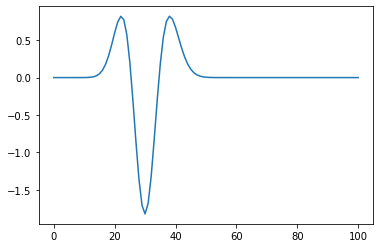

In [415]:
H = jax.hessian(pmf_jax_probs)(jax.scipy.special.logit(p), 100, np.arange(0, 101))
plt.plot(H)
plt.show()

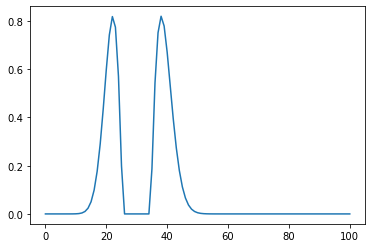

In [416]:
plt.plot(jnp.maximum(H, 0))
plt.show()

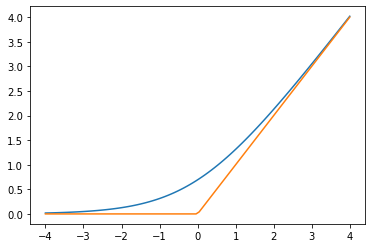

In [429]:
xs = np.linspace(-4, 4, 100)
plt.plot(xs, jax.nn.softplus(xs))
plt.plot(xs, jax.nn.relu(xs))
plt.show()

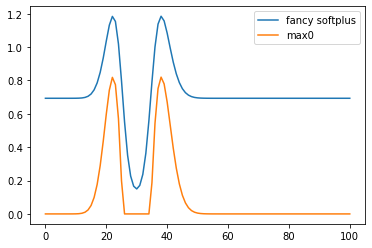

In [419]:
plt.plot(jax.nn.softplus(H), label="fancy softplus")
plt.plot(jnp.maximum(H, 0), label="max0")
plt.legend()
plt.show()

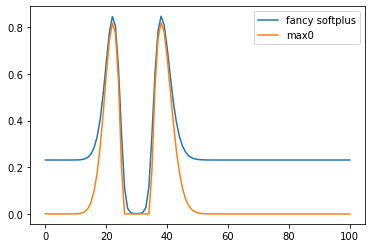

In [423]:
plt.plot(jax.nn.softplus(H * 3) / 3, label="fancy softplus")
plt.plot(jnp.maximum(H, 0), label="max0")
plt.legend()
plt.show()

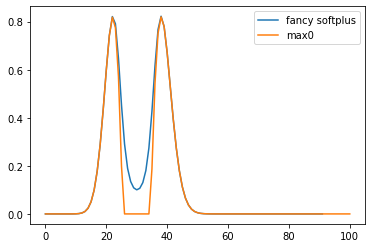

In [424]:
plt.plot(jax.nn.softplus(0.1 * H / pmf) * pmf / 0.1, label="fancy softplus")
plt.plot(jnp.maximum(H, 0), label="max0")
plt.legend()
plt.show()

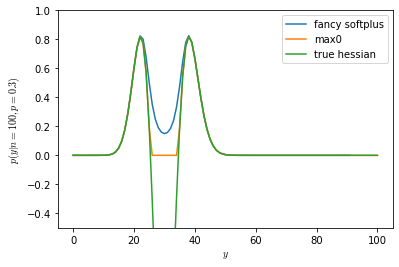

In [433]:
H = jax.hessian(pmf_jax_probs)(jax.scipy.special.logit(p), 100, np.arange(0, 101))
pmf = pmf_jax_probs(jax.scipy.special.logit(p), 100, np.arange(0, 101))
beta = np.max(pmf)
plt.plot(jax.nn.softplus(beta * H / pmf) * pmf / beta, label="fancy softplus")
plt.plot(jnp.maximum(H, 0), label="max0")
plt.plot(H, label="true hessian")
plt.legend()
plt.ylim([-0.5, 1.0])
plt.xlabel("$y$")
plt.ylabel("$p(y|n=100, p=0.3)$")
plt.show()

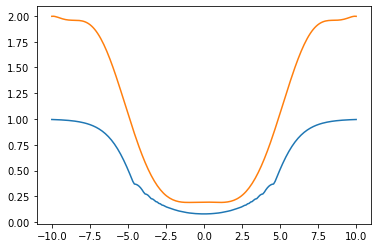

In [380]:
# but max(pmf) is not smooth, so fit a polynomial
def max_pmf(eta):
    return jnp.max(pmf_jax_probs(eta, 100, np.arange(0, 101)))


etas = np.linspace(-10, 10, 200)
max_pmf = jax.vmap(max_pmf)(etas)
max_poly = np.polyfit(etas, max_pmf, 11)
plt.plot(etas, max_pmf)
plt.plot(etas, jnp.polyval(max_poly, etas) * 2)
plt.show()

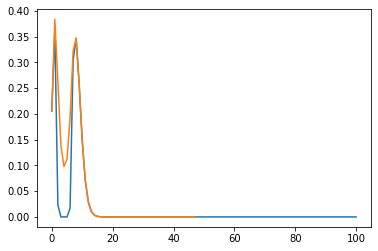

In [381]:
p = 0.04
pmf = pmf_jax_probs(jax.scipy.special.logit(p), 100, np.arange(0, 101))
H = jax.hessian(pmf_jax_probs)(jax.scipy.special.logit(p), 100, np.arange(0, 101))
beta = 2 * np.max(pmf)
plt.plot(jnp.maximum(H, 0))
plt.plot(jax.nn.softplus(beta * H / pmf) * pmf / beta)
plt.show()

In [382]:
pmf_jax = pmf_jax_probs

In [383]:
def bound_max0(eta, n, k):
    H = jax.hessian(pmf_jax)(eta, 100, np.arange(0, 101))
    max0H = jax.nn.relu(H)
    return jnp.sum(max0H)


bound_max0(jax.scipy.special.logit(0.5), 100, np.arange(0, 101))

DeviceArray(11.997778, dtype=float32)

In [408]:
def bound_softplus(eta, n, k):
    H = jax.hessian(pmf_jax)(eta, 100, np.arange(0, 101))
    eps = 1e-10
    pmf = pmf_jax(eta, 100, np.arange(0, 101))
    pmf = jnp.maximum(pmf, eps)
    beta = jnp.polyval(max_poly, eta) * 1.5
    softH = jax.nn.softplus(beta * H / pmf) * pmf / beta
    # softH = jnp.where(jnp.isnan(softH), 0, softH)
    return jnp.sum(softH)


bound_softplus(jax.scipy.special.logit(0.5), 100, np.arange(0, 101))

DeviceArray(12.937155, dtype=float32)

In [409]:
bound_f = bound_softplus
ps = np.linspace(0, 1, 200)[1:-1]
etas = jax.scipy.special.logit(ps)
bs = jax.vmap(bound_f, in_axes=(0, None, None))(etas, 100, np.arange(0, 101))
gs = jax.vmap(jax.grad(bound_f), in_axes=(0, None, None))(etas, 100, np.arange(0, 101))
hs = jax.vmap(jax.grad(jax.grad(bound_f)), in_axes=(0, None, None))(
    etas, 100, np.arange(0, 101)
)

In [410]:
import pandas as pd

df = pd.DataFrame(dict(p=ps, eta=etas, bound=bs, grad=gs, hess=hs))
df

,p,eta,bound,grad,hess
0,0.005025,-5.288267,0.841959,0.371667,0.326693
1,0.010050,-4.590056,1.203134,0.698733,0.633453
2,0.015075,-4.179502,1.550989,1.015383,0.911402
3,0.020101,-3.886705,1.890149,1.311629,1.120196
4,0.025126,-3.658420,2.220055,1.584271,1.271610
...,...,...,...,...,...
193,0.974874,3.658420,2.220063,-1.584280,1.271594
194,0.979899,3.886707,1.890152,-1.311635,1.120185
195,0.984925,4.179502,1.550992,-1.015395,0.911411
196,0.989950,4.590058,1.203131,-0.698735,0.633467


<>:8: DeprecationWarning: invalid escape sequence \e
<>:8: DeprecationWarning: invalid escape sequence \e
/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_3429/1590528767.py:8: DeprecationWarning: invalid escape sequence \e
  plt.xlabel('$\eta$')


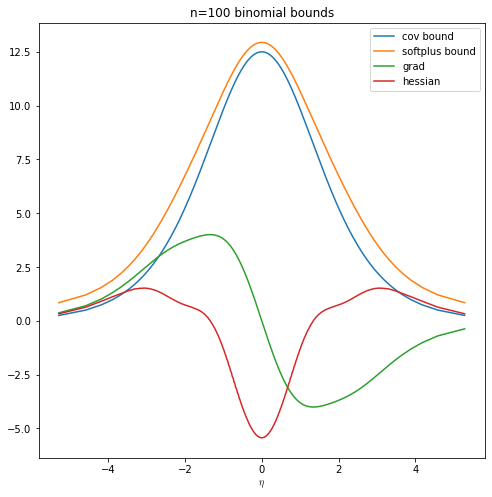

In [430]:
plt.figure(figsize=(8, 8))
plt.title("n=100 binomial bounds")
plt.plot(df["eta"], 0.5 * 100 * df["p"] * (1 - df["p"]), label="cov bound")
plt.plot(df["eta"], df["bound"], label="softplus bound")
plt.plot(df["eta"], df["grad"], label="grad")
plt.plot(df["eta"], df["hess"], label="hessian")
plt.legend()
plt.xlabel("$\eta$")
plt.show()